# Task 1 - Classification
Please check task1_response.pdf for detailed analysis

# a. Train 3 models: (1) speech features only (2) text features only (3) speech + text features

In [1]:
# Model: RandomForest (because one of the best performing esemble models)
# Speech Features Only

In [2]:
import pandas as pd
import numpy as np

In [3]:
!pip install xgboost

In [4]:
import sys
print(sys.base_prefix)
import pip
pip.main(['install', 'xgboost'])

/Users/gogorah/opt/anaconda3


Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


0

In [5]:
pip.main(['install', 'scikit-learn', '--upgrade'])

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


0

In [6]:
pip.main(['install', 'lime'])

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


0

In [7]:
from packaging import version
import sklearn
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [8]:
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

## (1) Speech Features Only Classification

In [9]:
# read prepared train speech data
train_speech_df = pd.read_csv("train_speech_prepared.csv", index_col=0)
train_speech_df

Min Pitch  Max Pitch  Mean Pitch  Sd Pitch  Min Intensity  \
0       0.054081   0.173285    0.080115  0.063913       0.839304   
1       0.034580   0.888478    0.072859  0.295127       0.850429   
2       0.033968   0.892975    0.085276  0.341877       0.841096   
3       0.074676   0.102706    0.063788  0.029259       0.850495   
4       0.031060   0.090622    0.047770  0.049846       0.839570   
...          ...        ...         ...       ...            ...   
77654   0.065897   0.051833    0.042545  0.009479       0.888480   
77655   0.561698   0.609320    0.608495  0.058584       0.021900   
77656   0.060399   0.256175    0.082640  0.117604       0.846711   
77657   0.080767   0.063325    0.056319  0.010348       0.903101   
77658   0.049134   0.814838    0.146474  0.408198       0.839884   

       Max Intensity  Mean Intensity  Sd Intensity  Speaking Rate    Jitter  \
0           0.901914        0.876320      0.051175       0.000241  0.054151   
1           0.882206        0.865878      0.037279       0.000254  0.098073   
2           0.927942        0.910148      0.078529       0.009962  0.107883   
3           0.923285        0.917939      0.088259       0.003679  0.089149   
4           0.928587        0.918019      0.078288       0.007263  0.080020   
...              ...             ...           ...            ...       ...   
77654       0.901209        0.904453      0.024449       0.006539  0.043077   
77655       0.842093        0.831087      0.388606       0.001015  0.157880   
77656       0.875480        0.866441      0.037091       0.001166  0.098813   
77657       0.877234        0.888965      0.005609       0.022429  0.147411   
77658       0.916247        0.909779      0.045369       0.014539  0.138277   

        Shimmer       HNR Target  
0      0.096284  0.376949      x  
1      0.112775  0.334062      x  
2      0.128477  0.359122     sv  
3      0.112315  0.378543      b  
4      0.072728  0.365332     sd  
...         ...       ...    ...  
77654  0.082768  0.348973      b  
77655  0.216352  0.246676      x  
77656  0.101363  0.317314      x  
77657  0.123549  0.328749      b  
77658  0.099025  0.342543     sv  

[77659 rows x 13 columns]

In [10]:
# splitting to X and y for train set
X_train_speech = train_speech_df.iloc[:, :-1].values
y_train = train_speech_df.iloc[:, -1].values
print(f"X_train shape: {X_train_speech.shape}\ny_train shape: {y_train.shape}")
print(y_train)

X_train shape: (77659, 12)
y_train shape: (77659,)
['x' 'x' 'sv' ... 'x' 'b' 'sv']


In [11]:
# splitting to X and y for test set
test_speech_df = pd.read_csv("test_speech_prepared.csv", index_col=0)
X_test_speech = test_speech_df.iloc[:, :-1].values
y_test = test_speech_df.iloc[:, -1].values
print(f"X_test shape: {X_test_speech.shape}\ny_test shape: {y_test.shape}")
print(y_test)

X_test shape: (13029, 12)
y_test shape: (13029,)
['x' '%' '%' ... 'sd' 'x' 'sd']


In [12]:
# encode categorical target into integers
ord_enc = OrdinalEncoder()
y_train = ord_enc.fit_transform(y_train.reshape(-1,1)).flatten()
y_test = ord_enc.transform(y_test.reshape(-1,1)).flatten()
print(ord_enc.categories_)
print(y_train)

[array(['%', 'aa', 'b', 'ba', 'fc', 'ny', 'qy', 'sd', 'sv', 'x'],
      dtype=object)]
[9. 9. 8. ... 9. 2. 8.]


In [13]:
# defining accuracy function
def get_accuracy(pred, true):
    return np.mean(pred==true)

In [14]:
# random forest classifier initialization for speech model
rnd_clf_speech = RandomForestClassifier(random_state=4231)

In [15]:
# check cross validation scores
cross_val_score(rnd_clf_speech, X_train_speech, y_train, cv=3)

array([0.70606868, 0.70729352, 0.70431894])

In [16]:
# train model
rnd_clf_speech.fit(X_train_speech, y_train)

RandomForestClassifier(random_state=4231)

In [17]:
# test
y_pred_speech = rnd_clf_speech.predict(X_test_speech)
speech_acc = get_accuracy(y_pred_speech, y_test)
print(f"Speech Only Test Accuracy: {speech_acc}")

Speech Only Test Accuracy: 0.6920715327346688


In [18]:
# check classification report
target_names = ord_enc.categories_[0]
print(classification_report(y_test, y_pred_speech, target_names=target_names))

              precision    recall  f1-score   support

           %       0.31      0.09      0.14       811
          aa       0.20      0.05      0.09       491
           b       0.56      0.77      0.65      1838
          ba       0.50      0.01      0.02       170
          fc       0.00      0.00      0.00       165
          ny       0.00      0.00      0.00       166
          qy       0.00      0.00      0.00       204
          sd       0.60      0.92      0.73      3526
          sv       0.24      0.02      0.04      1257
           x       0.91      0.96      0.94      4401

    accuracy                           0.69     13029
   macro avg       0.33      0.28      0.26     13029
weighted avg       0.61      0.69      0.62     13029



In [19]:
f1_speech = f1_score(y_test, y_pred_speech, average="weighted")
print(f"Speech Test F1 Score: {f1_speech}") 
# If with imbalanced data but want to assign greater contribution to classes 
# with more examples in the dataset, then the weighted average is preferred

Speech Test F1 Score: 0.621119211383789


## (2) Text Only Classification

In [20]:
# load train and test text data
train_text_df = pd.read_csv("train_text_prepared.csv", index_col=0)
test_text_df = pd.read_csv("test_text_prepared.csv", index_col=0)

In [21]:
# check
train_text_df

function   pronoun     ppron         i   we       you  shehe      they  \
0      0.000000  0.000000  0.000000  0.000000  0.0  0.000000    0.0  0.000000   
1      0.000000  0.000000  0.000000  0.000000  0.0  0.000000    0.0  0.000000   
2      0.642857  0.285714  0.190476  0.000000  0.0  0.142857    0.0  0.047619   
3      0.000000  0.000000  0.000000  0.000000  0.0  0.000000    0.0  0.000000   
4      0.666667  0.250000  0.250000  0.083333  0.0  0.083333    0.0  0.083333   
...         ...       ...       ...       ...  ...       ...    ...       ...   
77654  0.000000  0.000000  0.000000  0.000000  0.0  0.000000    0.0  0.000000   
77655  0.000000  0.000000  0.000000  0.000000  0.0  0.000000    0.0  0.000000   
77656  0.000000  0.000000  0.000000  0.000000  0.0  0.000000    0.0  0.000000   
77657  0.000000  0.000000  0.000000  0.000000  0.0  0.000000    0.0  0.000000   
77658  0.600000  0.200000  0.200000  0.000000  0.0  0.200000    0.0  0.000000   

          ipron   article  ...  relig  death  informal  swear  netspeak  \
0      0.000000  0.000000  ...    0.0    0.0  0.000000    0.0       0.0   
1      0.000000  0.000000  ...    0.0    0.0  0.000000    0.0       0.0   
2      0.095238  0.047619  ...    0.0    0.0  0.071429    0.0       0.0   
3      0.000000  0.000000  ...    0.0    0.0  1.000000    0.0       0.0   
4      0.000000  0.000000  ...    0.0    0.0  0.083333    0.0       0.0   
...         ...       ...  ...    ...    ...       ...    ...       ...   
77654  0.000000  0.000000  ...    0.0    0.0  1.000000    0.0       0.0   
77655  0.000000  0.000000  ...    0.0    0.0  0.000000    0.0       0.0   
77656  0.000000  0.000000  ...    0.0    0.0  0.000000    0.0       0.0   
77657  0.000000  0.000000  ...    0.0    0.0  1.000000    0.0       0.0   
77658  0.000000  0.000000  ...    0.0    0.0  0.000000    0.0       0.0   

       assent    nonflu  filler  num_words  Target  
0         0.0  0.000000     0.0   0.000000       x  
1         0.0  0.000000     0.0   0.000000       x  
2         0.0  0.071429     0.0   0.539474      sv  
3         1.0  0.000000     0.0   0.000000       b  
4         0.0  0.083333     0.0   0.144737      sd  
...       ...       ...     ...        ...     ...  
77654     1.0  0.000000     0.0   0.000000       b  
77655     0.0  0.000000     0.0   0.000000       x  
77656     0.0  0.000000     0.0   0.000000       x  
77657     1.0  0.000000     0.0   0.000000       b  
77658     0.0  0.000000     0.0   0.118421      sv  

[77659 rows x 75 columns]

In [22]:
# split into X and y for train text set
X_train_text = train_text_df.iloc[:, :-1].values
print(f"X_train shape: {X_train_text.shape}\ny_train shape: {y_train.shape}")

# split into X and y for test text set
X_test_text = test_text_df.iloc[:, :-1].values
print(f"X_test shape: {X_test_text.shape}\ny_test shape: {y_test.shape}")

print(y_test)

X_train shape: (77659, 74)
y_train shape: (77659,)
X_test shape: (13029, 74)
y_test shape: (13029,)
[9. 0. 0. ... 7. 9. 7.]


In [24]:
# init model for text data and check validation score
rnd_clf_text = RandomForestClassifier(random_state=4231)
cross_val_score(rnd_clf_text, X_train_text, y_train, cv=3)

array([0.81654885, 0.81719849, 0.81951634])

In [25]:
# train
rnd_clf_text.fit(X_train_text, y_train)

RandomForestClassifier(random_state=4231)

In [26]:
# test
y_pred_text = rnd_clf_text.predict(X_test_text)
text_acc = get_accuracy(y_pred_text, y_test)
print(f"Text Only Test Accuracy: {text_acc}")

Text Only Test Accuracy: 0.8086576099470412


In [27]:
# check classification report
target_names = ord_enc.categories_[0]
print(classification_report(y_test, y_pred_text, target_names=target_names))

              precision    recall  f1-score   support

           %       0.70      0.60      0.65       811
          aa       0.67      0.33      0.44       491
           b       0.75      0.98      0.85      1838
          ba       0.76      0.58      0.66       170
          fc       0.82      0.28      0.42       165
          ny       0.33      0.01      0.01       166
          qy       0.73      0.33      0.46       204
          sd       0.73      0.88      0.80      3526
          sv       0.54      0.32      0.40      1257
           x       0.99      1.00      0.99      4401

    accuracy                           0.81     13029
   macro avg       0.70      0.53      0.57     13029
weighted avg       0.79      0.81      0.79     13029



In [28]:
# print weight f1 score
f1_text = f1_score(y_test, y_pred_text, average="weighted")
print(f"Text Test F1 Score: {f1_text}")

Text Test F1 Score: 0.7869954757072635


## (3) Speech + Text Classification

In [29]:
# combine text and speech data for train set
X_train_all = np.hstack((X_train_speech, X_train_text))
print(f"X_train shape: {X_train_all.shape}\ny_train shape: {y_train.shape}")

# combine text and speech data for test set
X_test_all = np.hstack((X_test_speech, X_test_text))
print(f"X_test shape: {X_test_all.shape}\ny_test shape: {y_test.shape}")

print(y_test)

X_train shape: (77659, 86)
y_train shape: (77659,)
X_test shape: (13029, 86)
y_test shape: (13029,)
[9. 0. 0. ... 7. 9. 7.]


In [30]:
# init model for combined data and check validation scores
rnd_clf = RandomForestClassifier(random_state=4231)
cross_val_score(rnd_clf, X_train_all, y_train, cv=3)

array([0.81311083, 0.81391486, 0.81542146])

In [31]:
# train
rnd_clf.fit(X_train_all, y_train)

RandomForestClassifier(random_state=4231)

In [32]:
# test
y_pred_all = rnd_clf.predict(X_test_all)
all_acc = get_accuracy(y_pred_all, y_test)
print(f"Speech + Text Test Accuracy: {all_acc}")

Speech + Text Test Accuracy: 0.8032849796607567


In [33]:
# check classification report
target_names = ord_enc.categories_[0]
print(classification_report(y_test, y_pred_all, target_names=target_names))

              precision    recall  f1-score   support

           %       0.66      0.62      0.64       811
          aa       0.62      0.32      0.42       491
           b       0.75      0.95      0.84      1838
          ba       0.77      0.53      0.63       170
          fc       0.80      0.26      0.39       165
          ny       0.00      0.00      0.00       166
          qy       0.78      0.29      0.43       204
          sd       0.72      0.89      0.80      3526
          sv       0.54      0.27      0.36      1257
           x       0.98      1.00      0.99      4401

    accuracy                           0.80     13029
   macro avg       0.66      0.51      0.55     13029
weighted avg       0.78      0.80      0.78     13029



In [34]:
# print weight f1 score for combined dataset
f1_all = f1_score(y_test, y_pred_all, average="weighted")
print(f"Speech + Text Test F1 Score: {f1_all}")

Speech + Text Test F1 Score: 0.7789129077362031


# b. Describe the classification model(s) that you used and report the results for each feature set in tabular form.
In text file

# c. For the best performing model:

## c-a. Which feature set performed the best?
Best performing model was text only model (the result of text only and text+speech were similar, but based on the test set f1 score and accuracy text only model was better)

## c-b. Show the confusion matrix.

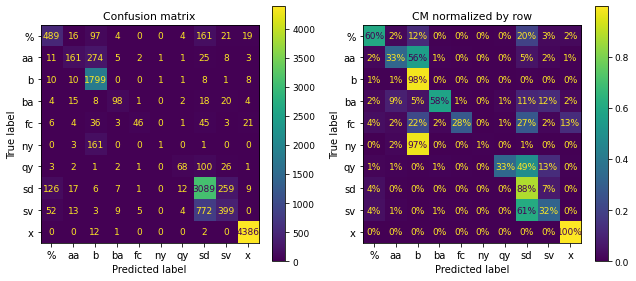

In [35]:
# show confusion matrix and normalized confusion matrix by row
# reference from handson machine learning book by Aurélien Géron 
from pathlib import Path

IMAGES_PATH = Path() / "plots"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

plt.rc('font', size=9)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_text, ax=axs[0], display_labels=ord_enc.categories_[0])
axs[0].set_title("Confusion matrix")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_text, ax=axs[1],
                                        normalize="true", values_format=".0%",
                                       display_labels=ord_enc.categories_[0])
axs[1].set_title("CM normalized by row")
plt.tight_layout()
plt.savefig(IMAGES_PATH/"confusion_matrix_text.png", format="png", dpi=300)
plt.show()

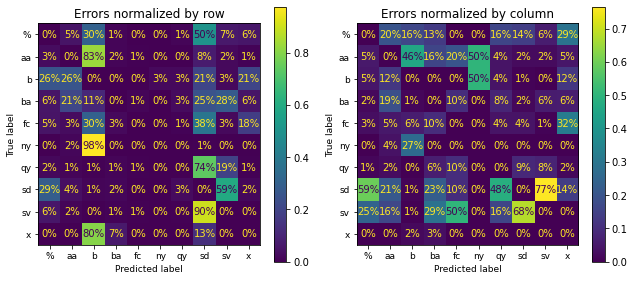

In [36]:
# show error in percentage by row (by true label) and by column (by predicted label)
# reference from handson machine learning book by Aurélien Géron 

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
plt.rc('font', size=10)

weight = (y_pred_text != y_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_text, ax=axs[0],
                                        sample_weight=weight,
                                        normalize="true", values_format=".0%",
                                       display_labels=ord_enc.categories_[0])
axs[0].set_title("Errors normalized by row")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_text, ax=axs[1],
                                        sample_weight=weight,
                                        normalize="pred", values_format=".0%",
                                       display_labels=ord_enc.categories_[0])
axs[1].set_title("Errors normalized by column")
plt.tight_layout()
plt.savefig(IMAGES_PATH/"confusion_error_text.png", format="png", dpi=300)
plt.show()
plt.rc('font', size=14)  # make fonts great again

In [37]:
# print classification report for text dataset model again
print(classification_report(y_test, y_pred_text, target_names=target_names))

              precision    recall  f1-score   support

           %       0.70      0.60      0.65       811
          aa       0.67      0.33      0.44       491
           b       0.75      0.98      0.85      1838
          ba       0.76      0.58      0.66       170
          fc       0.82      0.28      0.42       165
          ny       0.33      0.01      0.01       166
          qy       0.73      0.33      0.46       204
          sd       0.73      0.88      0.80      3526
          sv       0.54      0.32      0.40      1257
           x       0.99      1.00      0.99      4401

    accuracy                           0.81     13029
   macro avg       0.70      0.53      0.57     13029
weighted avg       0.79      0.81      0.79     13029



## c-c. Which class(es) were easiest to predict? Why do you think they were easy?

In [38]:
# checking if all values of scaled x were minimum value (==0)
row_zero_val_count = (train_text_df[train_text_df["Target"] == "x"].drop(columns=["Target"]) == 0.0).all(axis=1).count()
row_zero_val_count - (train_text_df["Target"] == "x").sum()

0

In [39]:
# c. Which class(es) were easiest to predict? Why do you think they were easy?
# dialogue act 'x' was the easiest to predict. x is for Non-verbal class. I believe it was easiest to distinguish
# for the model because for every scaled text features Non-verbal class has the minimum value which is 0.
# meaning class Non-verbal has almost no text features, 
# obviously Non-verbal speech act would not have words so for text feature related to words would be 0 for Non-verbal
# class. 
# so it would easier for the model to classify that out
# also class x was accounted for almost 39% of the whole train data
# so the model would be well trained to correctly predict data for class x

## c-d. Which were the most difficult? Why do you think they were difficult?

In [40]:
# d. Which were the most difficult? Why do you think they were difficult? (one with the lowest f1 score)
# the hardest one was 'ny' which is for Yes-answers.
# the model predicted ny to be b which is for Acknowledge (Backchannel).
# we can see that b is well classified with 98% while 97% of ny was predicted to be b
# The reason would be that Acknowledge and Yes-answers have similar qualities in text features
# which will lead to similar text feature values
# and since b has 10028 rows while ny has only 729 rows of data in train set
# the model would be trained to more likely to predict as b when with similar text features were given

In [41]:
# checking dataset balance
from collections import Counter
t = y_train.reshape(-1,1)
Counter(ord_enc.inverse_transform(t).flatten())

Counter({'x': 29998,
         'sv': 7428,
         'b': 10028,
         'sd': 19364,
         '%': 4294,
         'aa': 3014,
         'ba': 1112,
         'fc': 649,
         'qy': 1043,
         'ny': 729})

Target
%      5.529301
aa     3.881070
b     12.912863
ba     1.431901
fc     0.835705
ny     0.938719
qy     1.343051
sd    24.934650
sv     9.564893
x     38.627847
Name: Target, dtype: float64


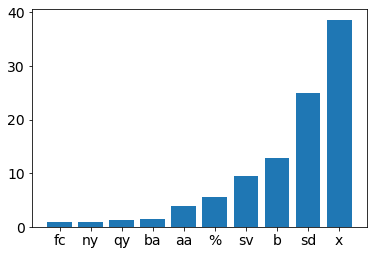

In [42]:
# plot number of each class
count_per_class = train_text_df.groupby("Target")["Target"].count() / len(train_text_df) * 100
print(count_per_class)
plt.bar(count_per_class.sort_values().index, count_per_class.sort_values())
plt.show()

## c-e. What were some common errors (e.g. confused classes)? Why do you think your classifier made these errors?
besides ny class,
the model classified aa (Agree, Accept) class as b, this would be
fc (Conventional-closing) was confused with sd -> fc having assent or informal or num_words but less num_words to b
qy (Yes-No-Question) was confused with sd -> 
sv (Statement-opinion) was confused with sd
fc, qy, and sv would have similar textual traits as sd (Statement-Non opinion). For example, sd and sv are both statements
so they would have commonalities of statements.
but sd(88% of predictions were correct) was relatively well predicted.
We can assume that text-wise, fc, qy, sv have similar qualities as sd and hard to distinguish by these text features.
Since tree models are more likely to predict similar data into a class with more data 
this can the problem of skewed dataset.

In [43]:
# this is for model behaviour analysis
import lime
import lime.lime_tabular
explainer = lime.lime_tabular.LimeTabularExplainer(X_train_text, 
                                                   feature_names=list(test_text_df.columns[:-1]), 
                                                   class_names=ord_enc.categories_[0], 
                                                   discretize_continuous=True)

/var/folders/c4/dgtyjv595nd6rr69jsl_26m00000gp/T/ipykernel_64449/3305409871.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  (test_text_df[test_text_df["Target"] == "ny"].mean()), color='green')
/var/folders/c4/dgtyjv595nd6rr69jsl_26m00000gp/T/ipykernel_64449/3305409871.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  plt.barh(test_text_df.columns[:-1], -test_text_df[test_text_df["Target"] == "b"].mean())


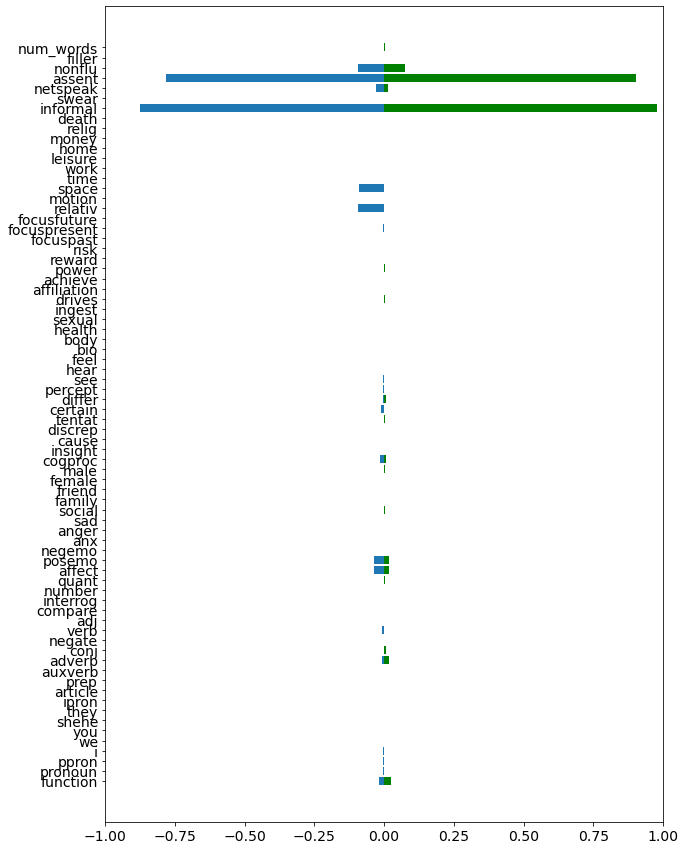

In [57]:
# ny and b; most ny misclassified as b
plt.figure(figsize=(10,15))
plt.xlim((-1,1))
plt.barh((test_text_df.columns[:-1]), 
         (test_text_df[test_text_df["Target"] == "ny"].mean()), color='green')
plt.barh(test_text_df.columns[:-1], -test_text_df[test_text_df["Target"] == "b"].mean())
plt.show()

/var/folders/c4/dgtyjv595nd6rr69jsl_26m00000gp/T/ipykernel_64449/1905038175.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  (test_text_df[test_text_df["Target"] == "aa"].mean()), color='r')
/var/folders/c4/dgtyjv595nd6rr69jsl_26m00000gp/T/ipykernel_64449/1905038175.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  plt.barh(test_text_df.columns[:-1], -test_text_df[test_text_df["Target"] == "b"].mean())


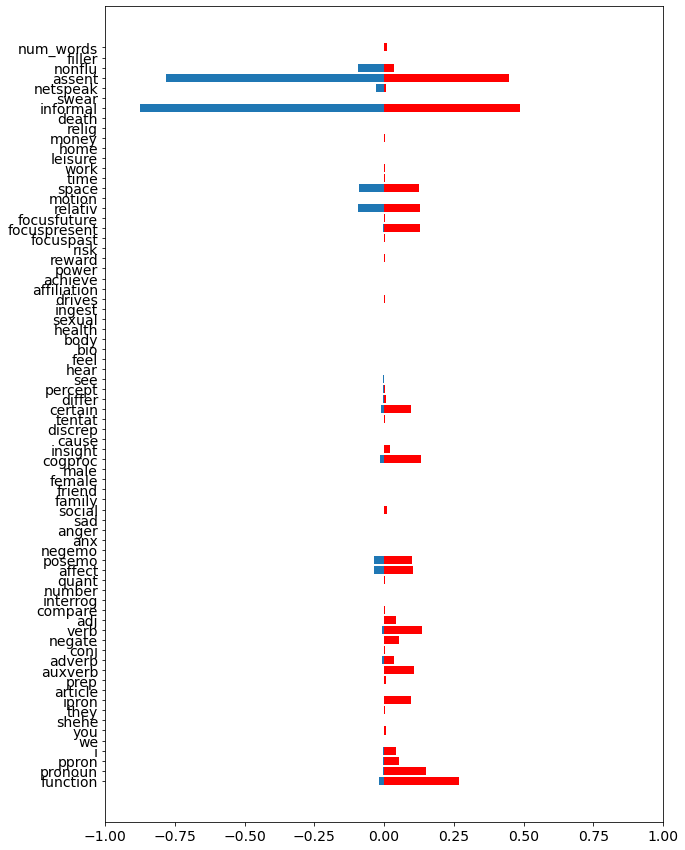

In [44]:
# aa and b; a often misclassified as b
plt.figure(figsize=(10,15))
plt.xlim((-1,1))
plt.barh((test_text_df.columns[:-1]), 
         (test_text_df[test_text_df["Target"] == "aa"].mean()), color='r')
plt.barh(test_text_df.columns[:-1], -test_text_df[test_text_df["Target"] == "b"].mean())
plt.show()

In [45]:
test_text_df[test_text_df["Target"] == "aa"]

function   pronoun     ppron    i   we       you  shehe  they  ipron  \
57     0.000000  0.000000  0.000000  0.0  0.0  0.000000    0.0   0.0    0.0   
58     0.000000  0.000000  0.000000  0.0  0.0  0.000000    0.0   0.0    0.0   
160    0.000000  0.000000  0.000000  0.0  0.0  0.000000    0.0   0.0    0.0   
162    0.333333  0.333333  0.333333  0.0  0.0  0.333333    0.0   0.0    0.0   
213    0.000000  0.000000  0.000000  0.0  0.0  0.000000    0.0   0.0    0.0   
...         ...       ...       ...  ...  ...       ...    ...   ...    ...   
12879  0.000000  0.000000  0.000000  0.0  0.0  0.000000    0.0   0.0    0.0   
12880  0.500000  0.500000  0.000000  0.0  0.0  0.000000    0.0   0.0    0.5   
12967  0.000000  0.000000  0.000000  0.0  0.0  0.000000    0.0   0.0    0.0   
12968  0.000000  0.000000  0.000000  0.0  0.0  0.000000    0.0   0.0    0.0   
13003  0.000000  0.000000  0.000000  0.0  0.0  0.000000    0.0   0.0    0.0   

       article  ...  relig  death  informal  swear  netspeak    assent  \
57         0.0  ...    0.0    0.0  0.000000    0.0       0.0  0.000000   
58         0.0  ...    0.0    0.0  1.000000    0.0       0.0  1.000000   
160        0.0  ...    0.0    0.0  0.000000    0.0       0.0  0.000000   
162        0.0  ...    0.0    0.0  0.333333    0.0       0.0  0.333333   
213        0.0  ...    0.0    0.0  1.000000    0.0       0.0  1.000000   
...        ...  ...    ...    ...       ...    ...       ...       ...   
12879      0.0  ...    0.0    0.0  1.000000    0.0       0.0  1.000000   
12880      0.0  ...    0.0    0.0  0.000000    0.0       0.0  0.000000   
12967      0.0  ...    0.0    0.0  0.000000    0.0       0.0  0.000000   
12968      0.0  ...    0.0    0.0  1.000000    0.0       0.0  1.000000   
13003      0.0  ...    0.0    0.0  1.000000    0.0       0.0  1.000000   

       nonflu  filler  num_words  Target  
57        0.0     0.0   0.000000      aa  
58        0.0     0.0   0.000000      aa  
160       0.0     0.0   0.000000      aa  
162       0.0     0.0   0.026316      aa  
213       0.0     0.0   0.000000      aa  
...       ...     ...        ...     ...  
12879     0.0     0.0   0.000000      aa  
12880     0.0     0.0   0.013158      aa  
12967     0.0     0.0   0.000000      aa  
12968     0.0     0.0   0.000000      aa  
13003     0.0     0.0   0.000000      aa  

[491 rows x 75 columns]

In [46]:
exp = explainer.explain_instance(X_test_text[58], rnd_clf_text.predict_proba, num_features=74, top_labels=1)
exp.show_in_notebook(show_table=True, show_all=False)

In [47]:
exp = explainer.explain_instance(X_test_text[12880], rnd_clf_text.predict_proba, num_features=74, top_labels=1)
exp.show_in_notebook(show_table=True, show_all=False)

/var/folders/c4/dgtyjv595nd6rr69jsl_26m00000gp/T/ipykernel_64449/1296929656.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  (test_text_df[test_text_df["Target"] == "qy"].mean()))
/var/folders/c4/dgtyjv595nd6rr69jsl_26m00000gp/T/ipykernel_64449/1296929656.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  plt.barh(test_text_df.columns[:-1], -test_text_df[test_text_df["Target"] == "sd"].mean())


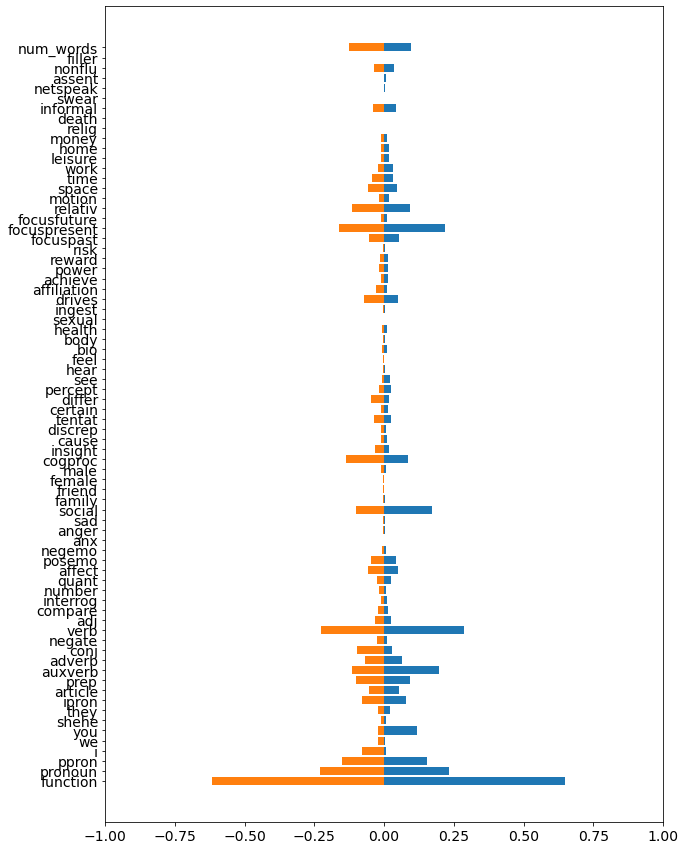

In [48]:
# qy and sd; qy often misclassified as sd
plt.figure(figsize=(10,15))
plt.xlim((-1,1))
plt.barh((test_text_df.columns[:-1]), 
         (test_text_df[test_text_df["Target"] == "qy"].mean()))
plt.barh(test_text_df.columns[:-1], -test_text_df[test_text_df["Target"] == "sd"].mean())
plt.show()

/var/folders/c4/dgtyjv595nd6rr69jsl_26m00000gp/T/ipykernel_64449/993864864.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  plt.barh((test_text_df.columns[:-1]), test_text_df[test_text_df["Target"] == "qy"].mean())
/var/folders/c4/dgtyjv595nd6rr69jsl_26m00000gp/T/ipykernel_64449/993864864.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  plt.barh(test_text_df.columns[:-1], -test_text_df[test_text_df["Target"] == "fc"].mean())


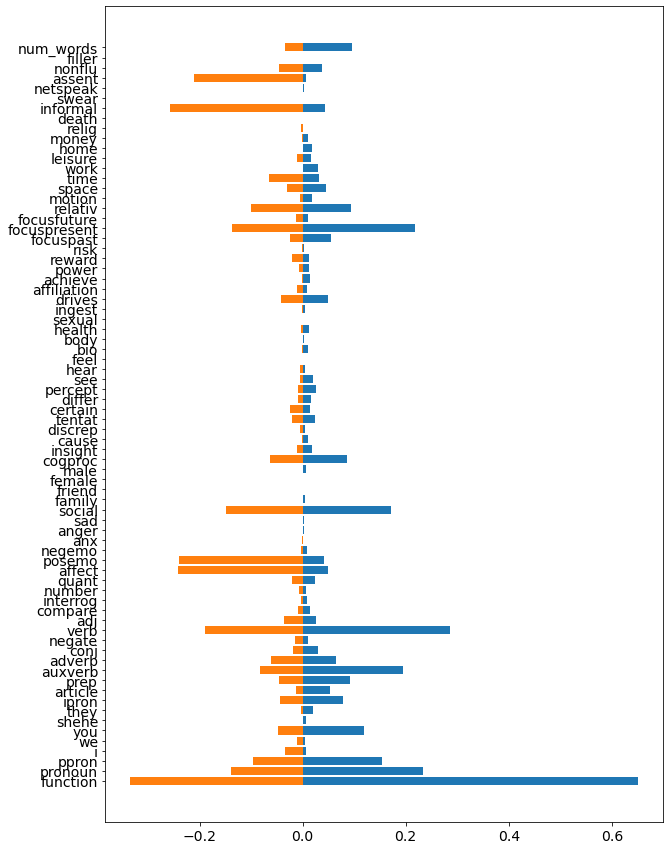

In [49]:
# qy and fc -> not similar features example
plt.figure(figsize=(10,15))

plt.barh((test_text_df.columns[:-1]), test_text_df[test_text_df["Target"] == "qy"].mean())
plt.barh(test_text_df.columns[:-1], -test_text_df[test_text_df["Target"] == "fc"].mean())
plt.show()

/var/folders/c4/dgtyjv595nd6rr69jsl_26m00000gp/T/ipykernel_64449/757179075.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  (test_text_df[test_text_df["Target"] == "sv"].mean()), color="r")
/var/folders/c4/dgtyjv595nd6rr69jsl_26m00000gp/T/ipykernel_64449/757179075.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  plt.barh(test_text_df.columns[:-1], -test_text_df[test_text_df["Target"] == "sd"].mean())


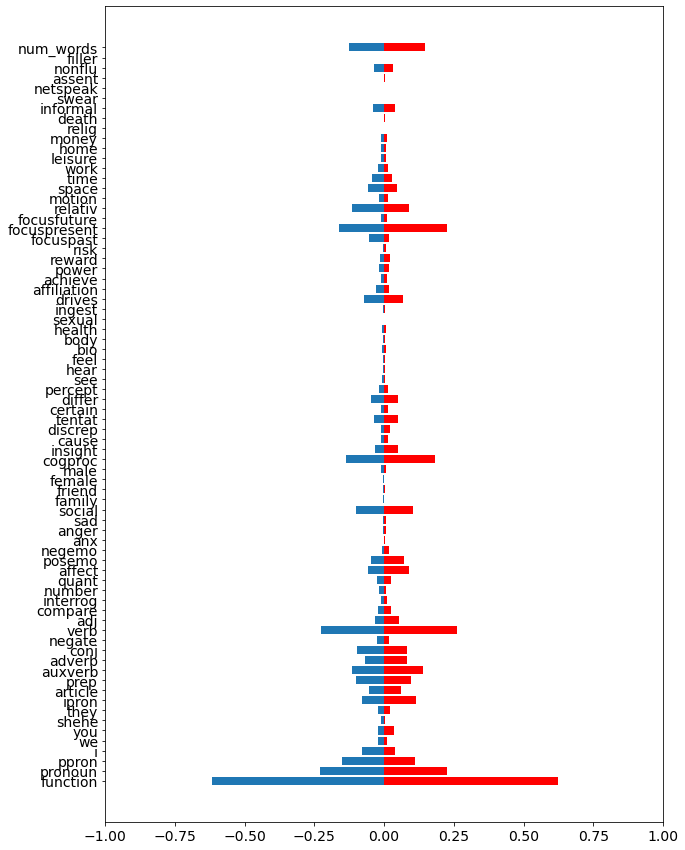

In [50]:
# sv and sd; sv often misclassified as sd
plt.figure(figsize=(10,15))
plt.xlim((-1,1))
plt.barh((test_text_df.columns[:-1]), 
         (test_text_df[test_text_df["Target"] == "sv"].mean()), color="r")
plt.barh(test_text_df.columns[:-1], -test_text_df[test_text_df["Target"] == "sd"].mean())
plt.show()
# very similar average values for a lot of the text features

/var/folders/c4/dgtyjv595nd6rr69jsl_26m00000gp/T/ipykernel_64449/2394639075.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  (test_text_df[test_text_df["Target"] == "fc"].mean()), color="red")
/var/folders/c4/dgtyjv595nd6rr69jsl_26m00000gp/T/ipykernel_64449/2394639075.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  plt.barh(test_text_df.columns[:-1], -test_text_df[test_text_df["Target"] == "sd"].mean())


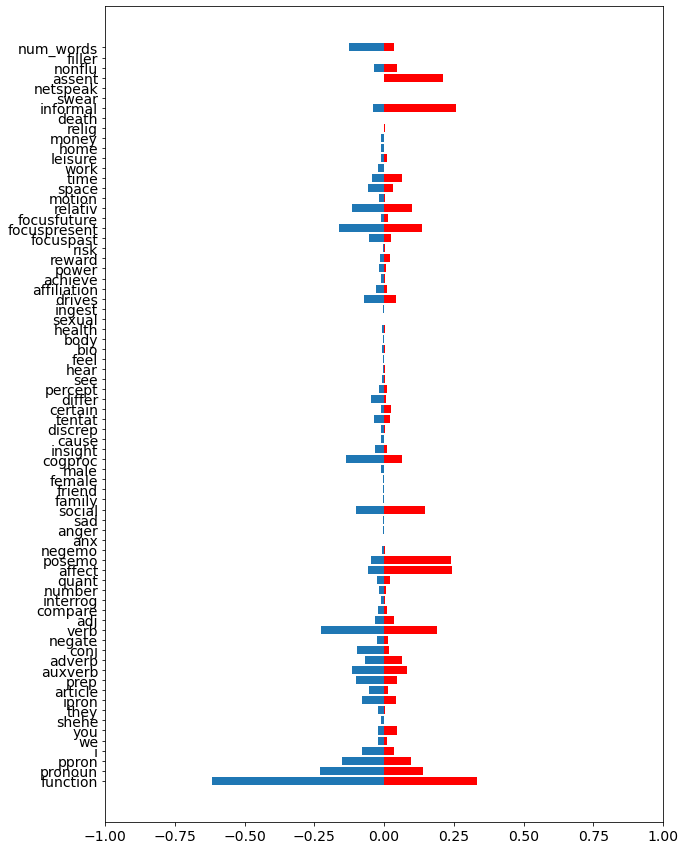

In [60]:
# fc and sd; fc often misclassified as sd
plt.figure(figsize=(10,15))
plt.xlim((-1,1))
plt.barh((test_text_df.columns[:-1]), 
         (test_text_df[test_text_df["Target"] == "fc"].mean()), color="red")
plt.barh(test_text_df.columns[:-1], -test_text_df[test_text_df["Target"] == "sd"].mean())
plt.show()

/var/folders/c4/dgtyjv595nd6rr69jsl_26m00000gp/T/ipykernel_64449/1844447780.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  (test_text_df[test_text_df["Target"] == "fc"].mean()), color="red")
/var/folders/c4/dgtyjv595nd6rr69jsl_26m00000gp/T/ipykernel_64449/1844447780.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  plt.barh(test_text_df.columns[:-1], -test_text_df[test_text_df["Target"] == "b"].mean(), color="green")


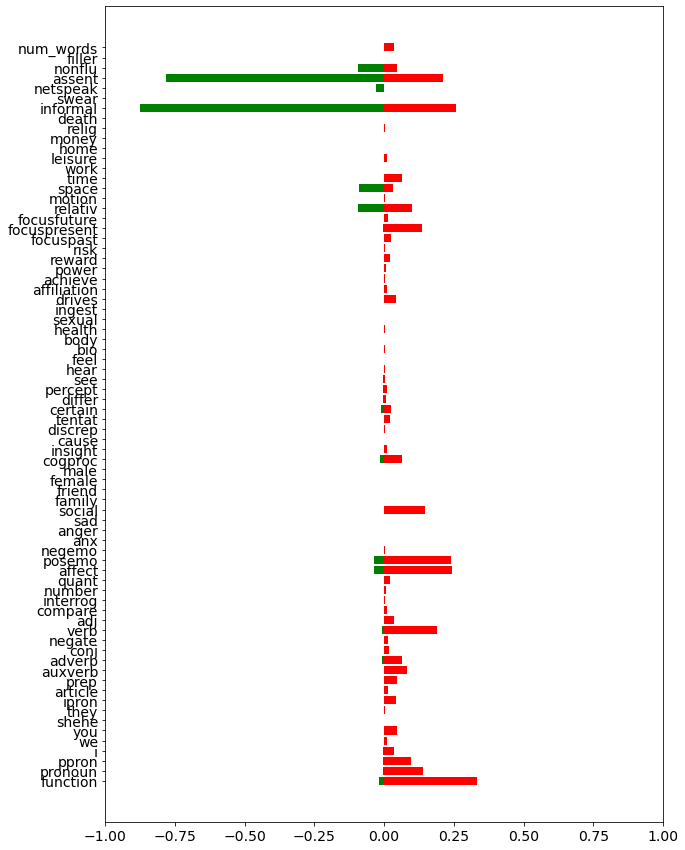

In [63]:
# fc and b; fc often misclassified as b
plt.figure(figsize=(10,15))
plt.xlim((-1,1))
plt.barh((test_text_df.columns[:-1]), 
         (test_text_df[test_text_df["Target"] == "fc"].mean()), color="red")
plt.barh(test_text_df.columns[:-1], -test_text_df[test_text_df["Target"] == "b"].mean(), color="green")
plt.show()

In [53]:
# sample of fc misclassified as b
exp = explainer.explain_instance(X_test_text[403], rnd_clf_text.predict_proba, num_features=74, top_labels=1)
exp.show_in_notebook(show_table=True, show_all=False)

In [54]:
# sample of fc corretly classified
exp = explainer.explain_instance(X_test_text[186], rnd_clf_text.predict_proba, num_features=74, top_labels=1)
exp.show_in_notebook(show_table=True, show_all=False)

In [55]:
# sample of fc misclassified as sd
exp = explainer.explain_instance(X_test_text[406], rnd_clf_text.predict_proba, num_features=74, top_labels=1)
exp.show_in_notebook(show_table=True, show_all=False)

## c-f. Based on this analysis, what ideas do you have to further improve your classifier/model?
First we can try to obtain more samples to better train the model and resolve imbalanced data issue
Second as obtaining more data sometimes can be a very time consuming and inexpensive process, we can try to
randomly oversample minor classes or use more advanced methods such as SMOTE to oversample the data.
another option might be to use different feature set or add features that can help distinguish classes that were hard
to discriminate from each other. Probably selecting useful speech features can help to distinguish the data.
Another option can be to use different types of models and compare them to get the best model for this dataset.